# Load in data

In [1]:
import pandas as pd
import numpy as np

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

# tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from scikeras.wrappers import KerasClassifier

pd.set_option('display.max_columns', 100)

In [2]:
# make sure GPU is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# memory management of GPU
gpu = tf.config.experimental.list_physical_devices('GPU')
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu[0], True)
    except RuntimeError as e:
        print(e)

In [4]:
# load in data, 'converters' turns str dtype -> list
df = pd.read_csv('../data/train_cleaned.csv', converters={'cleaned': pd.eval}, index_col='Unnamed: 0')

# join lists as single string
df['words'] = df.cleaned.apply(lambda x: " ".join(x))

df.head(2)

,cleaned,class,words
0,"[catheterization, laboratory, event, hospital,...",3,catheterization laboratory event hospital outc...
1,"[renal, abscess, child, three, renal, abscess,...",4,renal abscess child three renal abscess child ...


# Target Variable

In [5]:
# look at class distribution
df['class'].value_counts(normalize=True)

class
4    0.332802
0    0.219075
3    0.211317
2    0.133329
1    0.103477
Name: proportion, dtype: float64

- 0: Neoplasms
- 1: Digestive system diseases
- 2: Nervous system diseases
- 3: Cardiovascular diseases
- 4: General pathological conditions

We chose to drop class 4, as the 'general' category hindered our model's ability to generalize.

In [6]:
# drop class 4
df2 = df.loc[df['class'] < 4]

In [7]:
# shapes of data
df.shape[0], df2.shape[0]

(14438, 9633)

- This reduced sample size from 14.4k to 9.6k
- We feel like this drop was for the best, as it allowed our models to classify documents with much greater accuracy

# Custom functions

### Look at input features

In [19]:
# vectorize
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df2.words)

# shape of input data
X.shape

(9633, 27268)

- Over 27k unique unigrams in our dataset
- This number will change based on params passed into the vectorizer
- We used SVD (Singular Value Decomposition) to reduce the dimensionality of our vectorized data, reducing our feature space to around 100

### models df

In [ ]:
# empty df to store NN results and params
keras_df = pd.DataFrame(columns=['train_acc', 'train_loss', 'test_acc', 'test_loss', 'num_layers', 'shape', 'optim', 
                                 'epochs', 'batch_size', 'vec_name', 'vec_feats', 'vec_min', 'vec_max'])
keras_df

### Custom functions

In [ ]:
# train NN, return acc, loss, and model parameters
# def fit_eval(node_list, vectorizer, data=df, results_df=keras_df):

#     '''
    
#     Parameters:
#     node_list - a list containing node counts for hidden layers

#     Returns:
#     results_df - df (passed in) with the results appended from the nn, params of NN also included
    
#     '''
    
#     # split train and test data
#     X_train, X_test, y_train, y_test = train_test_split(data.words, data['class'], test_size=0.2, random_state=0)
    
#     # preprocess data
#     X_train = vectorizer.fit_transform(X_train).toarray()
#     X_test = vectorizer.transform(X_test).toarray()
    
#     # further split the training data into training and validation sets
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
    
#     # one-hot encode our labels
#     y_train = to_categorical(y_train)
#     y_val = to_categorical(y_val)
#     y_test = to_categorical(y_test)
    
#     # add early stopping -> if model doesn't decrease val_loss every 5 epochs, exit the fitting process
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

#     # create the KerasClassifier, use build_model (defined in cell below) as build function
#     nn = KerasClassifier(model=build_model(X_train.shape[1], node_list), epochs=1000, batch_size=32, optimizer=Adam(), 
#                          validation_split=0.2, verbose=0, loss='categorical_crossentropy', callbacks=[early_stopping])
    
#     # fit nn
#     nn.fit(X_train, y_train, validation_data=(X_val, y_val))
    
#     # accuracy
#     train_acc = nn.score(X_train, y_train)
#     test_acc = nn.score(X_test, y_test)
    
#     # prediction probabilities
#     train_preds = nn.predict_proba(X_train)
#     test_preds = nn.predict_proba(X_test)
    
#     # loss
#     train_loss = categorical_crossentropy(y_train, train_preds)
#     test_loss = categorical_crossentropy(y_test, test_preds)

#     # ========================================= get model/vectorizer params =========================================
    
#     # get number of layers
#     num_layers = len(nn.model.layers)

#     # get shape of nn
#     nn_shape = []
#     for i, layer in enumerate(nn.model.layers):
# #         if i % 2 == 0:
#         nn_shape.append(layer.units)

#     # optimizer, epochs, batch_size
#     optim = str(nn.optimizer).split()[0].split('.')[-1]
#     epochs = nn.current_epoch
#     batch_size = nn.batch_size
    
#     # vectorizer name, some parameters
#     vec_name = str(vec)[:-2]
#     vec_feats = vectorizer.max_features
#     vec_min = vectorizer.min_df
#     vec_max = vectorizer.max_df
    
    
#     # append results to the df
#     results_df.loc[len(results_df.index)] = [train_acc, train_loss, test_acc, test_loss, num_layers, nn_shape, optim, 
#                                              epochs, batch_size, vec_name, vec_feats, vec_min, vec_max]
    
    
    
#     return results_df

In [8]:
# function to build a keras model
def build_model(input_dim, node_list):
    '''
    Build and return a keras NN with a specified node count for each hidden layer.
    
    Parameters:
    input_dim - input dimensions (num features) to be passied into Input layer
    node_list - list where nth index value corresponds to nth hidden layer node count
    
    Returns:
    model - a keras NN
    
    '''
    
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    
    # add Dense hidden layers
    for node in node_list:
        model.add(Dense(node, activation=relu))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
    # output layer - 4 possible classes
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Format and split data

In [10]:
# global random state for reproducibility
random_state = 0

In [74]:
# create our vectorizer
vectorizer = TfidfVectorizer()

# LSA
svd = TruncatedSVD(n_components=100, random_state=random_state)

In [75]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(df2.words, df2['class'], test_size=0.2, random_state=random_state)

# vectorize input data
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.fit_transform(X_test).toarray()

# SVD transform the input data
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

# further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

# NN

In [76]:
# add early stopping -> if model doesn't decrease val_loss every 5 epochs, exit the fitting process
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [94]:
# create the KerasClassifier, use build_model to create our model
nn = KerasClassifier(model=build_model(X_train.shape[1], [100, 100]), epochs=100, batch_size=32, optimizer=Adam(),
                     callbacks=[early_stopping], validation_split=0.2, verbose=1, loss='sparse_categorical_crossentropy')

In [78]:
# fit nn
nn.fit(X_train, y_train, validation_data=(X_val, y_val))

# free up GPU memory
backend.clear_session()

Epoch 1/100
386/386 [==============================] - 4s 9ms/step - loss: 1.2836 - accuracy: 0.5281 - val_loss: 0.9137 - val_accuracy: 0.7315
Epoch 2/100
386/386 [==============================] - 3s 7ms/step - loss: 0.8380 - accuracy: 0.6922 - val_loss: 0.5511 - val_accuracy: 0.8268
Epoch 3/100
386/386 [==============================] - 2s 5ms/step - loss: 0.7259 - accuracy: 0.7404 - val_loss: 0.5250 - val_accuracy: 0.8333
Epoch 4/100
386/386 [==============================] - 2s 6ms/step - loss: 0.6689 - accuracy: 0.7573 - val_loss: 0.5083 - val_accuracy: 0.8346
Epoch 5/100
386/386 [==============================] - 3s 7ms/step - loss: 0.6418 - accuracy: 0.7758 - val_loss: 0.4986 - val_accuracy: 0.8327
Epoch 6/100
386/386 [==============================] - 3s 7ms/step - loss: 0.6238 - accuracy: 0.7789 - val_loss: 0.4894 - val_accuracy: 0.8366
Epoch 7/100
386/386 [==============================] - 3s 7ms/step - loss: 0.5986 - accuracy: 0.7910 - val_loss: 0.4926 - val_accuracy: 0.8314

- our best NN achieved a val_loss of about 0.45 with a val_acc of 83.4%

In [17]:
nn.score(X_test, y_test)

121/121 [==============================] - 0s 3ms/step


0.8188894654903995

- 81.9% test acc

In [16]:
y_preds = nn.predict(X_test)
print(classification_report(y_test, y_preds))

121/121 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       638
           1       0.82      0.75      0.78       304
           2       0.72      0.74      0.73       382
           3       0.87      0.86      0.87       603

    accuracy                           0.82      1927
   macro avg       0.81      0.80      0.81      1927
weighted avg       0.82      0.82      0.82      1927



- noteicably worse recall on classes 1 and 2
- will use class_weight to attempt to improve

### Add class weights

In [18]:
# what 'balanced' class weights would look like
y_train.shape[0] / (4 * np.bincount(y_train))

array([0.76704828, 1.59358842, 1.24074074, 0.79188078])

In [23]:
# less-intense class weights than the 'balanced' approach
class_weight={0: 0.8, 1: 1.4, 2: 1.2, 3: 0.8}

# create the KerasClassifier
nn2 = KerasClassifier(model=build_model(X_train.shape[1], [100, 100]), epochs=100, batch_size=16, optimizer=Adam(), 
                     callbacks=[early_stopping], class_weight=class_weight, validation_split=0.2, verbose=1, 
                     loss='sparse_categorical_crossentropy')

In [24]:
# fit nn2
nn2.fit(X_train, y_train, validation_data=(X_val, y_val))

# free up GPU memory
backend.clear_session()

Epoch 1/100
386/386 [==============================] - 4s 9ms/step - loss: 1.3290 - accuracy: 0.5127 - val_loss: 0.9237 - val_accuracy: 0.6096
Epoch 2/100
386/386 [==============================] - 3s 8ms/step - loss: 0.8675 - accuracy: 0.6770 - val_loss: 0.5704 - val_accuracy: 0.8139
Epoch 3/100
386/386 [==============================] - 3s 8ms/step - loss: 0.7354 - accuracy: 0.7326 - val_loss: 0.5466 - val_accuracy: 0.8236
Epoch 4/100
386/386 [==============================] - 3s 9ms/step - loss: 0.6771 - accuracy: 0.7529 - val_loss: 0.5331 - val_accuracy: 0.8243
Epoch 5/100
386/386 [==============================] - 3s 8ms/step - loss: 0.6531 - accuracy: 0.7716 - val_loss: 0.5402 - val_accuracy: 0.8145
Epoch 6/100
386/386 [==============================] - 3s 8ms/step - loss: 0.6318 - accuracy: 0.7773 - val_loss: 0.5134 - val_accuracy: 0.8307
Epoch 7/100
386/386 [==============================] - 3s 7ms/step - loss: 0.6063 - accuracy: 0.7854 - val_loss: 0.5153 - val_accuracy: 0.8184

- best val acc with optimized class weights was 83.0%

In [25]:
# test acc
nn.score(X_test, y_test)

121/121 [==============================] - 0s 2ms/step


0.8183705241307733

In [26]:
y_preds = nn.predict(X_test)
print(classification_report(y_test, y_preds))

121/121 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       638
           1       0.78      0.80      0.79       304
           2       0.70      0.79      0.74       382
           3       0.91      0.83      0.87       603

    accuracy                           0.82      1927
   macro avg       0.81      0.81      0.81      1927
weighted avg       0.82      0.82      0.82      1927



- class weight did improve recall for classes 1 and 2, but overall acc slightly decreased

# Stacking classifier

In [79]:
# create our vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# LSA
svd = TruncatedSVD(n_components=100, random_state=random_state)

In [80]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(df2.words, df2['class'], test_size=0.2, random_state=random_state)

# vectorize and SVD transform the input data
X_train = svd.fit_transform(vectorizer.fit_transform(X_train).toarray())
X_test = svd.transform(vectorizer.transform(X_test).toarray())

# # further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [81]:
# build stacking classifier
stack = StackingClassifier([
    ('logreg', LogisticRegression(max_iter=1000, penalty=None)),
    ('knn', KNeighborsClassifier(n_neighbors=20)),
    ('dt', DecisionTreeClassifier())
])

In [82]:
# train
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('logreg',
                                LogisticRegression(max_iter=1000,
                                                   penalty=None)),
                               ('knn', KNeighborsClassifier(n_neighbors=20)),
                               ('dt', DecisionTreeClassifier())])

In [83]:
# get scores
stack.score(X_train, y_train), stack.score(X_test, y_test)

(0.8221933809214795, 0.8147379346133887)

- our best stacker achieved 81.5% testing accuracy

# Manual stacking
- we are using the prediction probs from our best stacking classifier as input to a NN

### putting ONLY preds from stack into NN

In [66]:
# get pred probs from the best StackingClassifier
stack_train_preds = stack.predict_proba(X_train)
stack_val_preds = stack.predict_proba(X_val)
stack_test_preds = stack.predict_proba(X_test)

In [67]:
# create the KerasClassifier, input is stacker's preds
nn3 = KerasClassifier(model=build_model(stack_train_preds.shape[1], [100, 100]), epochs=100, batch_size=32,
                     optimizer=Adam(), callbacks=[early_stopping],
                     validation_split=0.2, verbose=1, loss='sparse_categorical_crossentropy')

In [68]:
# fit nn3
nn3.fit(stack_train_preds, y_train, validation_data=(stack_val_preds, y_val))

Epoch 1/100
193/193 [==============================] - 2s 6ms/step - loss: 0.8472 - accuracy: 0.7635 - val_loss: 0.9393 - val_accuracy: 0.7931
Epoch 2/100
193/193 [==============================] - 1s 5ms/step - loss: 0.6993 - accuracy: 0.7987 - val_loss: 0.6657 - val_accuracy: 0.8372
Epoch 3/100
193/193 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.8048 - val_loss: 0.5356 - val_accuracy: 0.8366
Epoch 4/100
193/193 [==============================] - 1s 5ms/step - loss: 0.6328 - accuracy: 0.8146 - val_loss: 0.5188 - val_accuracy: 0.8366
Epoch 5/100
193/193 [==============================] - 1s 6ms/step - loss: 0.6214 - accuracy: 0.8149 - val_loss: 0.5184 - val_accuracy: 0.8392
Epoch 6/100
193/193 [==============================] - 1s 6ms/step - loss: 0.6075 - accuracy: 0.8168 - val_loss: 0.5191 - val_accuracy: 0.8379
Epoch 7/100
193/193 [==============================] - 1s 6ms/step - loss: 0.5958 - accuracy: 0.8154 - val_loss: 0.5155 - val_accuracy: 0.8372

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x0000024BF70981F0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x0000024BF693C6A0>
	loss=sparse_categorical_crossentropy
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x0000024B57397460>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

- 83.9% val_acc but our val_loss only got down to 0.51

### putting preds from stack + input data into NN

In [69]:
# combine pred probs with input data
stack_train_full = np.concatenate((X_train, stack_train_preds), axis=1)
stack_val_full = np.concatenate((X_val, stack_val_preds), axis=1)
stack_test_full = np.concatenate((X_test, stack_test_preds), axis=1)

In [70]:
# create the KerasClassifier, pred probs + input data
nn4 = KerasClassifier(model=build_model(stack_train_full.shape[1], [104, 104]), epochs=100, batch_size=64, optimizer=Adam(), 
                     callbacks=[early_stopping], validation_split=0.2, verbose=1, loss='sparse_categorical_crossentropy')

In [71]:
# fit nn4
nn4.fit(stack_train_full, y_train, validation_data=(stack_val_full, y_val))

Epoch 1/100
97/97 [==============================] - 1s 9ms/step - loss: 0.8609 - accuracy: 0.7537 - val_loss: 1.1386 - val_accuracy: 0.6239
Epoch 2/100
97/97 [==============================] - 1s 6ms/step - loss: 0.6885 - accuracy: 0.7959 - val_loss: 1.0066 - val_accuracy: 0.6984
Epoch 3/100
97/97 [==============================] - 1s 7ms/step - loss: 0.6502 - accuracy: 0.8061 - val_loss: 0.8479 - val_accuracy: 0.7685
Epoch 4/100
97/97 [==============================] - 1s 8ms/step - loss: 0.6242 - accuracy: 0.8144 - val_loss: 0.7448 - val_accuracy: 0.8061
Epoch 5/100
97/97 [==============================] - 1s 7ms/step - loss: 0.6121 - accuracy: 0.8084 - val_loss: 0.5953 - val_accuracy: 0.8307
Epoch 6/100
97/97 [==============================] - 1s 6ms/step - loss: 0.5938 - accuracy: 0.8191 - val_loss: 0.5351 - val_accuracy: 0.8346
Epoch 7/100
97/97 [==============================] - 1s 7ms/step - loss: 0.5700 - accuracy: 0.8189 - val_loss: 0.5081 - val_accuracy: 0.8372
Epoch 8/100
9

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x0000024BF7098790>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x0000024BEBD722C0>
	loss=sparse_categorical_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x0000024B57397460>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

- val acc still at 83%. val_loss only down to 0.48

### Using difference between best NN pred probs and best Stacker pred probs as input

In [91]:
# get predictions from first (best) NN
nn_train_preds = nn.predict_proba(X_train)
nn_val_preds = nn.predict_proba(X_val)
nn_test_preds = nn.predict_proba(X_val)

97/97 [==============================] - 0s 2ms/step


In [92]:
# Calculate the diff
train_diff = stack_train_preds - nn_train_preds
val_diff = stack_val_preds - nn_val_preds
test_diff = stack_val_preds - nn_test_preds

# create the KerasClassifier, use diff as input data
nn5 = KerasClassifier(model=build_model(train_diff.shape[1], [64, 64, 32, 32]), epochs=100, batch_size=32, optimizer=Adam(), 
                     callbacks=[early_stopping], validation_split=0.2, verbose=1, loss='sparse_categorical_crossentropy')

In [93]:
# fit nn5
nn5.fit(train_diff, y_train, validation_data=(val_diff, y_val))

Epoch 1/100
193/193 [==============================] - 4s 16ms/step - loss: 1.4172 - accuracy: 0.4757 - val_loss: 0.9826 - val_accuracy: 0.5934
Epoch 2/100
193/193 [==============================] - 3s 15ms/step - loss: 0.9486 - accuracy: 0.6626 - val_loss: 0.6706 - val_accuracy: 0.7990
Epoch 3/100
193/193 [==============================] - 3s 15ms/step - loss: 0.8549 - accuracy: 0.7177 - val_loss: 0.5930 - val_accuracy: 0.8178
Epoch 4/100
193/193 [==============================] - 2s 12ms/step - loss: 0.8106 - accuracy: 0.7414 - val_loss: 0.5855 - val_accuracy: 0.8158
Epoch 5/100
193/193 [==============================] - 2s 12ms/step - loss: 0.7895 - accuracy: 0.7516 - val_loss: 0.5840 - val_accuracy: 0.8165
Epoch 6/100
193/193 [==============================] - 3s 13ms/step - loss: 0.7739 - accuracy: 0.7532 - val_loss: 0.5838 - val_accuracy: 0.8165
Epoch 7/100
193/193 [==============================] - 2s 10ms/step - loss: 0.7627 - accuracy: 0.7633 - val_loss: 0.5828 - val_accuracy:

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x0000024B92EBF820>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x0000024BFE639630>
	loss=sparse_categorical_crossentropy
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x0000024BFDE9F910>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

In [102]:
nn5.history_

defaultdict(list,
            {'loss': [1.4171557426452637,
              0.9486358761787415,
              0.8548996448516846,
              0.8106237053871155,
              0.7894542217254639,
              0.7738520503044128,
              0.7627252340316772,
              0.7597576379776001,
              0.7381932139396667,
              0.7304194569587708,
              0.7291144132614136,
              0.7325411438941956,
              0.7251919507980347,
              0.7318357825279236,
              0.7162026166915894,
              0.7301547527313232,
              0.7213820815086365,
              0.7159146666526794,
              0.7156200408935547,
              0.7207873463630676,
              0.7077929973602295,
              0.7137309908866882,
              0.7182705998420715,
              0.7118202447891235,
              0.7099007964134216],
             'accuracy': [0.4756651520729065,
              0.6625567674636841,
              0.7177157402038574,
         

- this was the worst NN so far

In [211]:
# train acc, test acc
nn5.score(train_residuals, y_train), nn5.score(test_residuals, y_test)

31/31 [==============================] - 0s 801us/step


(1.0, 1.0)

# Looking at different LSA vals

In [111]:
# create our vectorizer
vectorizer = TfidfVectorizer()

# split train and test
X_train, X_test, y_train, y_test = train_test_split(df2.words, df2['class'], test_size=0.2, random_state=random_state)

# vectorize input data
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [113]:
losses = []
accs = []

# look at LSA vals from 100-1000, incrementing by 100
for n in range(100, 1001, 100):
    # LSA
    svd = TruncatedSVD(n_components=n, random_state=random_state)

    # SVD transform the input data
    X_train_lsa = svd.fit_transform(X_train)
    X_test_lsa = svd.transform(X_test)
    
    # create the KerasClassifier, use build_model to create our model
    nn = KerasClassifier(model=build_model(X_train_lsa.shape[1], [100, 100]), epochs=100, batch_size=32, optimizer=Adam(),
                         callbacks=[early_stopping], validation_split=0.2, verbose=1, loss='sparse_categorical_crossentropy')
    
    # fit nn
    nn.fit(X_train_lsa, y_train)
    
    # append val_loss and val_acc from last epoch
    losses.append(nn.history_['val_loss'][-1])
    accs.append(nn.history_['val_accuracy'][-1])
    
    # free up GPU memory
    backend.clear_session()
    
# further split the training data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

Epoch 1/100
193/193 [==============================] - 3s 11ms/step - loss: 1.3800 - accuracy: 0.4912 - val_loss: 1.2238 - val_accuracy: 0.6835
Epoch 2/100
193/193 [==============================] - 2s 9ms/step - loss: 0.8702 - accuracy: 0.6763 - val_loss: 0.8546 - val_accuracy: 0.7970
Epoch 3/100
193/193 [==============================] - 2s 8ms/step - loss: 0.7298 - accuracy: 0.7356 - val_loss: 0.5947 - val_accuracy: 0.8197
Epoch 4/100
193/193 [==============================] - 2s 9ms/step - loss: 0.6708 - accuracy: 0.7646 - val_loss: 0.5355 - val_accuracy: 0.8204
Epoch 5/100
193/193 [==============================] - 2s 8ms/step - loss: 0.6489 - accuracy: 0.7740 - val_loss: 0.5292 - val_accuracy: 0.8210
Epoch 6/100
193/193 [==============================] - 1s 8ms/step - loss: 0.6178 - accuracy: 0.7818 - val_loss: 0.5252 - val_accuracy: 0.8210
Epoch 7/100
193/193 [==============================] - 2s 8ms/step - loss: 0.5970 - accuracy: 0.7883 - val_loss: 0.5193 - val_accuracy: 0.826

Epoch 10/100
193/193 [==============================] - 1s 6ms/step - loss: 0.4765 - accuracy: 0.8298 - val_loss: 0.5026 - val_accuracy: 0.8210
Epoch 11/100
193/193 [==============================] - 1s 7ms/step - loss: 0.4635 - accuracy: 0.8313 - val_loss: 0.5035 - val_accuracy: 0.8152
Epoch 12/100
193/193 [==============================] - 1s 8ms/step - loss: 0.4575 - accuracy: 0.8358 - val_loss: 0.5055 - val_accuracy: 0.8178
Epoch 13/100
193/193 [==============================] - 2s 9ms/step - loss: 0.4393 - accuracy: 0.8404 - val_loss: 0.5019 - val_accuracy: 0.8197
Epoch 14/100
193/193 [==============================] - 2s 9ms/step - loss: 0.4195 - accuracy: 0.8443 - val_loss: 0.5106 - val_accuracy: 0.8197
Epoch 14: early stopping
Epoch 1/100
193/193 [==============================] - 2s 6ms/step - loss: 1.5223 - accuracy: 0.4340 - val_loss: 1.2586 - val_accuracy: 0.4118
Epoch 2/100
193/193 [==============================] - 1s 6ms/step - loss: 0.9268 - accuracy: 0.6434 - val_loss:

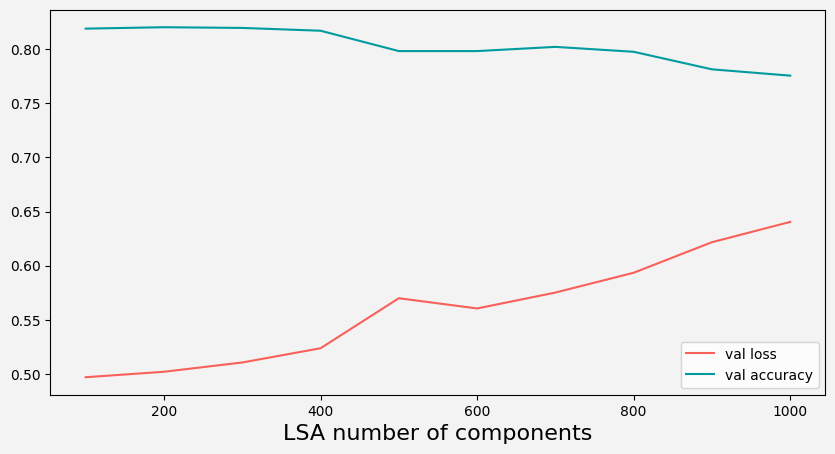

In [140]:
x = list(range(100, 1001, 100))

fig, ax = plt.subplots(figsize=(10,5), facecolor='#f3f3f3')
ax.set_facecolor('#f3f3f3')

# plt.title('')
plt.xlabel('LSA number of components', fontsize=16)

sns.lineplot(x=x, y=losses, label='val loss', color='#fa605a', ax=ax)
sns.lineplot(x=x, y=accs, label='val accuracy', color='#009b9f', ax=ax)

plt.savefig('LSA', transparent=True);